In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [5]:
# Load data
df = pd.read_csv(r"C:\Users\arpit\OneDrive\Desktop\Greenhouse emission prdeiction project\SupplyChainEmissionFactorsforUSIndustriesCommodities2015_Summary.csv")

In [6]:
# Clean data
df = df.dropna(subset=['Supply Chain Emission Factors with Margins'])
df = df.drop_duplicates()
df['Supply Chain Emission Factors with Margins'] = pd.to_numeric(df['Supply Chain Emission Factors with Margins'], errors='coerce')
df = df.dropna(subset=['Supply Chain Emission Factors with Margins'])

In [8]:
print(df.columns.tolist())


['Industry Code', 'Industry Name', 'Substance', 'Unit', 'Supply Chain Emission Factors without Margins', 'Margins of Supply Chain Emission Factors', 'Supply Chain Emission Factors with Margins', 'Unnamed: 7', 'DQ ReliabilityScore of Factors without Margins', 'DQ TemporalCorrelation of Factors without Margins', 'DQ GeographicalCorrelation of Factors without Margins', 'DQ TechnologicalCorrelation of Factors without Margins', 'DQ DataCollection of Factors without Margins']


In [9]:
feature_cols = [
    'Industry Name',
    'DQ ReliabilityScore of Factors without Margins',
    'DQ TemporalCorrelation of Factors without Margins',
    'DQ GeographicalCorrelation of Factors without Margins',
    'DQ TechnologicalCorrelation of Factors without Margins',
    'DQ DataCollection of Factors without Margins'
]

In [10]:
df_model = df[feature_cols].copy()
df_model = pd.get_dummies(df_model, drop_first=True)


In [11]:
X = df_model
y = df['Supply Chain Emission Factors with Margins']


In [12]:
# --- Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

In [14]:
results = {}

In [15]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2 Score': r2_score(y_test, y_pred)
    }

In [16]:
results_df = pd.DataFrame(results).T
print("Model Evaluation Results:")
print(results_df)

Model Evaluation Results:
                       RMSE       MAE  R2 Score
Linear Regression  0.187061  0.103113 -0.602963
Decision Tree      0.219246  0.105802 -1.202017
Random Forest      0.181222  0.087361 -0.504453


In [17]:
# --- Tune Random Forest ---
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

In [18]:

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)
best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)


In [19]:
print("\nTuned Random Forest Performance:")
print("Best Parameters:", grid.best_params_)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("MAE:", mean_absolute_error(y_test, y_pred_best))
print("R² Score:", r2_score(y_test, y_pred_best))



Tuned Random Forest Performance:
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
RMSE: 0.1636110692993101
MAE: 0.07639205634066888
R² Score: -0.22626468989771675


In [20]:
# --- Save Best Model ---
joblib.dump(best_rf, 'best_random_forest_model.pkl')

['best_random_forest_model.pkl']

In [21]:
# --- Visualizations ---

# Top 10 industries by average emission
top10 = df.groupby('Industry Name')['Supply Chain Emission Factors with Margins'].mean().sort_values(ascending=False).head(10).reset_index()

C:\Users\arpit\AppData\Local\Temp\ipykernel_16760\2611284872.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


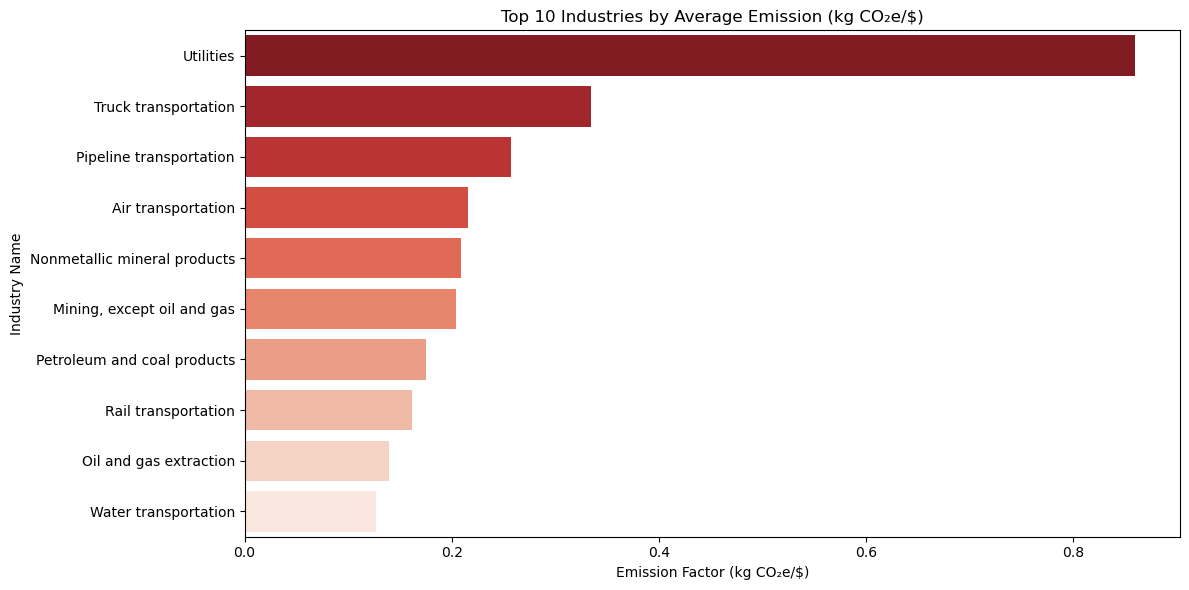

In [22]:

plt.figure(figsize=(12, 6))
sns.barplot(
    x='Supply Chain Emission Factors with Margins',
    y='Industry Name',
    data=top10,
    palette='Reds_r'
)
plt.title('Top 10 Industries by Average Emission (kg CO₂e/$)')
plt.xlabel('Emission Factor (kg CO₂e/$)')
plt.ylabel('Industry Name')
plt.tight_layout()
plt.show()

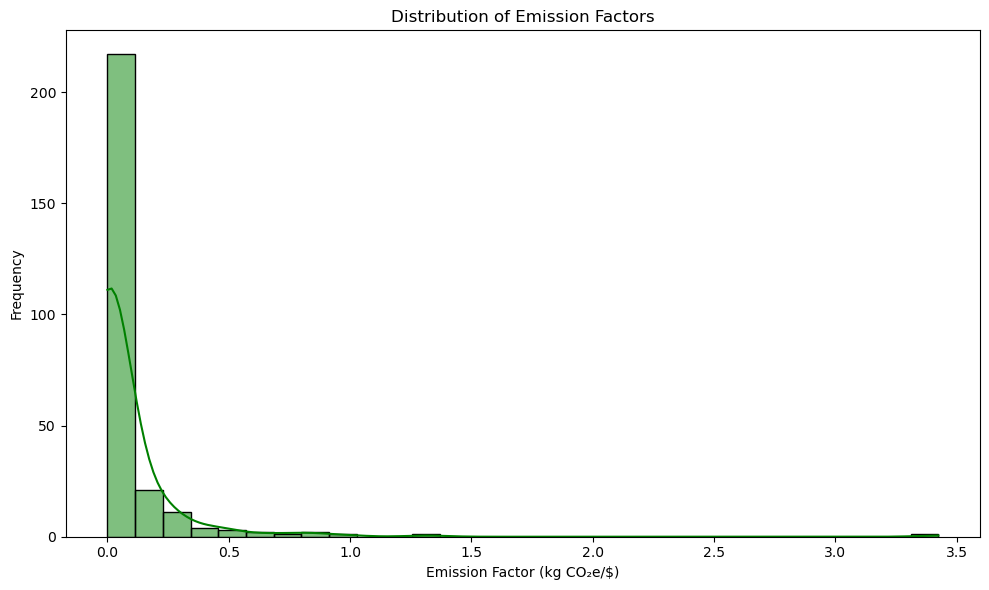

In [23]:
# Distribution of Emission Factors
plt.figure(figsize=(10, 6))
sns.histplot(df['Supply Chain Emission Factors with Margins'], bins=30, kde=True, color='green')
plt.title('Distribution of Emission Factors')
plt.xlabel('Emission Factor (kg CO₂e/$)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

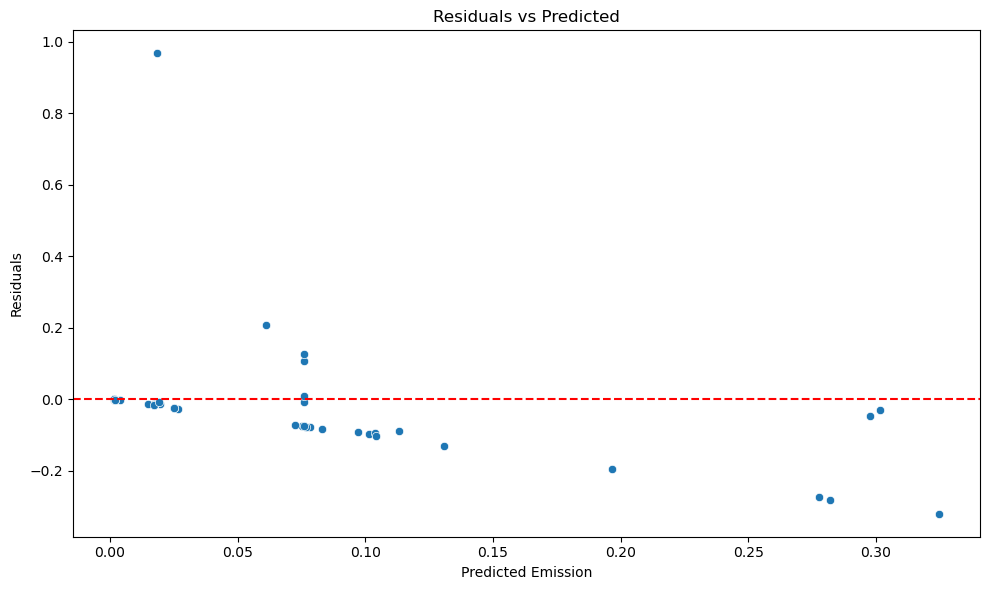

In [24]:

# Residual Plot
residuals = y_test - y_pred_best
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_best, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Emission')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

In [25]:
# Feature Importance Plot
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)


C:\Users\arpit\AppData\Local\Temp\ipykernel_16760\2216193672.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='Blues_r')


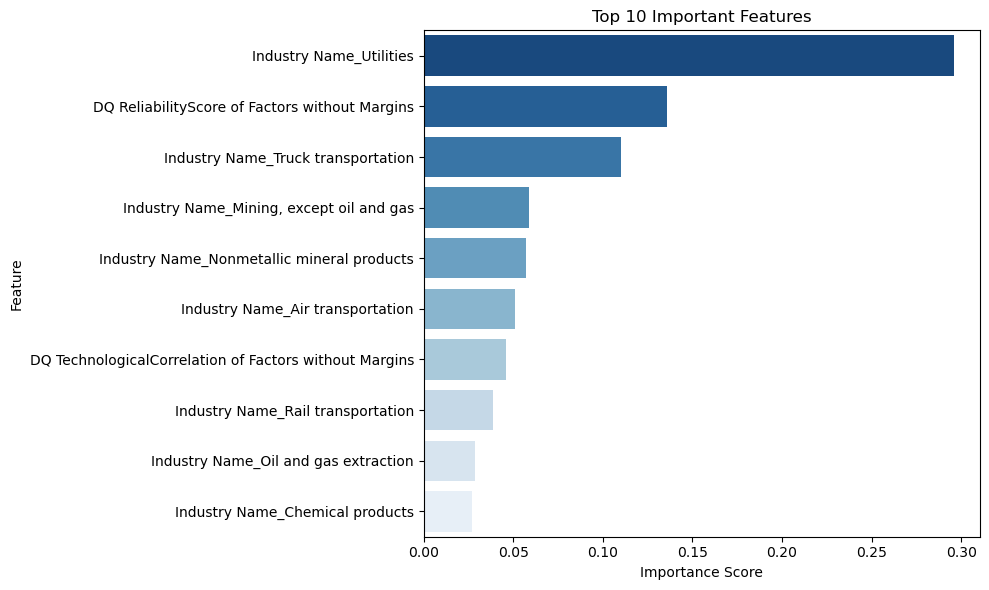

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='Blues_r')
plt.title('Top 10 Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()